In [48]:
import os

#TRAIN_DATA = os.path.join('..', 'data', 'processed', 'train.csv')
TRAIN_DATA = os.path.join('..', 'data', 'processed', 'train_balanced.csv')
TEST_DATA = os.path.join('..', 'data', 'processed', 'test.csv')

FEATURES_IT1 = [
    'GyroscopeStat_x_MEAN',
    'GyroscopeStat_z_MEAN',
    'GyroscopeStat_COV_z_x',
    'GyroscopeStat_COV_z_y',
    'MagneticField_x_MEAN',
    'MagneticField_z_MEAN',
    'MagneticField_COV_z_x',
    'MagneticField_COV_z_y',
    'Pressure_MEAN',
    'LinearAcceleration_COV_z_x',
    'LinearAcceleration_COV_z_y',
    'LinearAcceleration_x_MEAN',
    'LinearAcceleration_z_MEAN',
]
FEATURES_IT2 = FEATURES_IT1
FEATURES_IT3 = [
    'GyroscopeStat_x_MEAN',
    'GyroscopeStat_z_MEAN',
    'GyroscopeStat_COV_z_x',
    'GyroscopeStat_COV_z_y',
    #'MagneticField_x_MEAN',
    #'MagneticField_z_MEAN',
    #'MagneticField_COV_z_x',
    #'MagneticField_COV_z_y',
    #'Pressure_MEAN',
    'LinearAcceleration_COV_z_x',
    'LinearAcceleration_COV_z_y',
    'LinearAcceleration_x_MEAN',
    'LinearAcceleration_z_MEAN',
]

In [49]:
import os

import pandas as pd
import numpy as np

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [50]:
df_train = pd.read_csv(TRAIN_DATA)
df_test = pd.read_csv(TEST_DATA)
FEATURES = FEATURES_IT3


x_train = df_train[FEATURES]
y_train = df_train['attack']

x_test = df_test[FEATURES]
y_test = df_test['attack']


In [51]:
clf = RandomForestClassifier(n_estimators=512, n_jobs=-1)


In [52]:
param_dist = {  "max_features": ['auto', 'sqrt'],
                "max_depth": [10,9,8,7,6,5,4,3,2,None],
                "min_samples_split": sp_randint(2, 50),
                "min_samples_leaf": sp_randint(1, 50),
                "bootstrap": [True, False],
                "criterion": ["gini","entropy"]}

random_search = RandomizedSearchCV(clf,
            scoring = 'f1_micro',
            param_distributions = param_dist,
            n_iter = 10, verbose=1)

random_search.fit(x_train, y_train)

c:\users\alberto\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   13.2s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=512, n_jobs=-1,
                                                  

In [53]:
import sys

def report(results, n_top=3, out=sys.stdout): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            out.write("Model with rank: {0}\n".format(i))
            out.write("Mean validation score: {0:.3f} (std: {1:.3f})\n".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            out.write("Parameters: {0}\n".format(results['params'][candidate]))
            out.write("\n")
            out.flush()
            
report(random_search.cv_results_)

with open(os.path.join('..', 'report', 'it3', 'rf_search_results.txt'), 'w') as f:
    report(random_search.cv_results_, out=f)

Model with rank: 1
Mean validation score: 0.896 (std: 0.010)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.877 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 25}

Model with rank: 3
Mean validation score: 0.869 (std: 0.023)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 9, 'min_samples_split': 6}



In [54]:
clf_rf = RandomForestClassifier(n_estimators=512, criterion='entropy', 
                                max_depth=10, max_features='sqrt', 
                                min_samples_leaf=4, min_samples_split=10,
                                bootstrap=False, n_jobs=-1, 
                                class_weight=None)

clf_rf.fit(x_train, y_train) # Construcción del modelo

preds_rf = clf_rf.predict(x_test) # Test del modelo


In [55]:
from sklearn.metrics import classification_report

import sys
def report(out=sys.stdout):
    print("Random Forest:\n",
          classification_report(y_true=y_test, y_pred=preds_rf),
         file=out)

    # Confussion Matrix

    print("Confussion Matrixn:\n", file=out)
    matrix = pd.crosstab(y_test, preds_rf, rownames=['actual'], colnames=['preds'])
    print(matrix, file=out)

    # Variables relevantes

    print("Feature Relevance:\n", file=out)
    print(pd.DataFrame({
            'Feature': FEATURES ,
            'Relevancy': clf_rf.feature_importances_}),
          '\n',
         file=out)
    print("Maximum relevance RF:",
          max(clf_rf.feature_importances_),
          '\n',
         file=out)
    
report()
with open(os.path.join('..', 'report', 'it3', 'rf_report.txt'), 'w') as f:
    report(f)

Random Forest:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      4896
           1       0.02      0.88      0.04         8

    accuracy                           0.94      4904
   macro avg       0.51      0.91      0.51      4904
weighted avg       1.00      0.94      0.97      4904

Confussion Matrixn:

preds      0    1
actual           
0       4592  304
1          1    7
Feature Relevance:

                      Feature  Relevancy
0        GyroscopeStat_x_MEAN   0.132599
1        GyroscopeStat_z_MEAN   0.094129
2       GyroscopeStat_COV_z_x   0.102471
3       GyroscopeStat_COV_z_y   0.200070
4  LinearAcceleration_COV_z_x   0.191151
5  LinearAcceleration_COV_z_y   0.149714
6   LinearAcceleration_x_MEAN   0.072651
7   LinearAcceleration_z_MEAN   0.057215 

Maximum relevance RF: 0.20007049937995977 



In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.9379085 0.0620915]
 [0.125     0.875    ]]


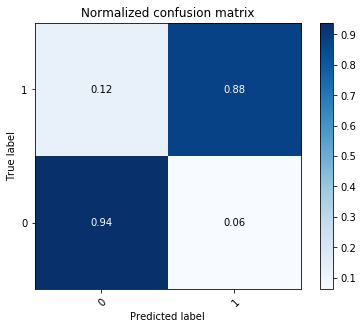

In [57]:
IMG_OUTPUT = os.path.join('..', 'report', 'it3', 'images')
os.makedirs(IMG_OUTPUT, exist_ok=True)

plot_confusion_matrix(y_test, preds_rf, classes = unique_labels(y_test, preds_rf), normalize=True,
                      title='Normalized confusion matrix')

plt.ylim((-0.5, 1.5))

plt.savefig(os.path.join(IMG_OUTPUT, 'rf_confusion_matrix.png'))